In [1]:
import numpy as np
import pandas as pd 
import random 
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import gc 

In [2]:
# load the data
train = pd.read_csv('train.csv')


In [3]:
train = train[train['answered_correctly'] != -1]
subset_id = train.groupby('user_id').agg({'answered_correctly':'count'}).reset_index().sample(frac=0.01, random_state=77)

In [4]:
train = train[train['user_id'].isin(subset_id['user_id'])]


In [5]:
del train['timestamp']  
del train['row_id']
del train['task_container_id']
del train['content_type_id']
gc.collect()

120

In [6]:
questions = pd.read_csv('questions.csv')
train_questions=train.merge(questions,left_on='content_id',right_on='question_id',how='left')
del questions
train_questions_gp=train_questions.groupby('question_id').agg({'answered_correctly':['mean','count','std']}).reset_index()
train_questions_gp.columns=['question_id','q_correct','q_count','q_std']
train_questions_gp.q_std = train_questions_gp.q_std.fillna(train_questions_gp.q_std.mean())
del train_questions
gc.collect()
train=train.merge(train_questions_gp,left_on='content_id',right_on='question_id',how='left')
del train_questions_gp

In [7]:
user_flags = train.groupby('user_id').agg({'answered_correctly':['mean','count','min','max','std']}).reset_index()
user_flags.columns=['user_id','user_answer_mean','user_answer_count','user_min','user_max','user_std']
user_flags.user_std = user_flags.user_std.fillna(user_flags.user_std.mean())
user_flags.isnull().sum()
gc.collect()
train=train.merge(user_flags,on=['user_id'],how='left')
del user_flags
gc.collect()

0

In [8]:
train

,user_id,content_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,q_correct,q_count,q_std,user_answer_mean,user_answer_count,user_min,user_max,user_std
0,2285289,3606,3,1,NaN,NaN,3606,0.750000,32,0.439941,0.620690,29,0,1,0.493804
1,2285289,1069,3,1,9000.0,False,1069,0.817708,192,0.387094,0.620690,29,0,1,0.493804
2,2285289,5673,2,0,18000.0,False,5673,0.428571,462,0.495408,0.620690,29,0,1,0.493804
3,2285289,8918,1,0,13000.0,False,8918,0.433962,53,0.500363,0.620690,29,0,1,0.493804
4,2285289,5547,1,0,21000.0,False,5547,0.380952,42,0.491507,0.620690,29,0,1,0.493804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017581,2147025654,13517,0,0,22000.0,True,13517,0.750000,8,0.462910,0.436364,55,0,1,0.500505
1017582,2147025654,754,3,0,11000.0,True,754,0.666667,156,0.472923,0.436364,55,0,1,0.500505
1017583,2147025654,846,0,0,14000.0,True,846,0.709677,124,0.455753,0.436364,55,0,1,0.500505
1017584,2147025654,1309,1,1,15000.0,True,1309,0.392308,260,0.489206,0.436364,55,0,1,0.500505


In [9]:
from sklearn.model_selection import train_test_split #Splitting data for model training
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
#NA Values of Prior Question had Explanation with False
train['prior_question_had_explanation'].fillna(False, inplace=True)
    
#Prior Question Elapsed Time MVT
train['prior_question_elapsed_time'].fillna(25302, inplace=True)
X=train.loc[:,[ 'prior_question_elapsed_time',
       'prior_question_had_explanation','question_id','q_correct','q_count','q_std' ,'user_answer_mean',
    'user_answer_count', 'user_min', 'user_max', 'user_std']]#Selecting feature variables

Y=train['answered_correctly'] #Selecting the output columns
feature_list=X.columns

In [10]:
X_train,X_test,Y_train,Y_test=train_test_split(X, Y,test_size=0.3,random_state=1)

In [11]:
X_train

,prior_question_elapsed_time,prior_question_had_explanation,question_id,q_correct,q_count,q_std,user_answer_mean,user_answer_count,user_min,user_max,user_std
261320,51000.0,True,3925,0.666667,57,0.475595,0.684851,5921,0,1,0.464615
721998,22000.0,True,9538,0.826923,52,0.382005,0.782675,658,0,1,0.412739
164860,56000.0,True,6659,0.270968,310,0.445178,0.656911,615,0,1,0.475127
969913,2000.0,False,730,0.649123,171,0.478646,0.240260,154,0,1,0.428635
581322,33000.0,True,6264,0.334320,338,0.472451,0.641935,930,0,1,0.479689
...,...,...,...,...,...,...,...,...,...,...,...
491263,20000.0,True,10608,1.000000,51,0.000000,0.661290,62,0,1,0.477134
791624,42000.0,True,3650,0.456140,57,0.502500,0.367021,752,0,1,0.482313
470924,18000.0,True,1224,0.807971,276,0.394611,0.619718,142,0,1,0.487174
491755,6000.0,False,5213,0.602941,408,0.489889,0.885714,70,0,1,0.320455


In [12]:
Y_train

261320    1
721998    1
164860    1
969913    0
581322    1
         ..
491263    1
791624    0
470924    1
491755    1
128037    1
Name: answered_correctly, Length: 712310, dtype: int64

# Logistic Regression 


## Logistic model with L2 norm and sag  solver

In [23]:
param = {
 'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False
}

from sklearn.feature_selection import RFE


clf1 = LogisticRegression(solver = 'sag',C = 1.0, penalty = 'l2', max_iter = 100)

clf1.fit(X_train,Y_train)


/Users/jiachenliu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(solver='sag')

### accurancy score

In [24]:
clf1.score(X_test,Y_test)

0.6566942701031198

### ROC score

In [25]:
y_pred = clf1.predict(X_test) #prelim
Y_test=np.asarray(Y_test)
y_score = clf1.predict_proba(X_test)
roc_prelim=roc_auc_score(np.asarray(Y_test), y_pred)
roc=roc_auc_score(np.asarray(Y_test), y_score[:, 1])
print("ROC : {:.5}".format(roc))

ROC : 0.52794


## Logistic model with L1 norm and sag  solver

In [26]:
clf = LogisticRegression(solver = 'liblinear',C = 1.0, penalty = 'l1', max_iter = 100)

clf.fit(X_train,Y_train)

LogisticRegression(penalty='l1', solver='liblinear')

### accurancy score

In [30]:
clf.score(X_test,Y_test)

0.7166138183152295

### Roc Score

In [32]:
clf.score(X_test,Y_test)
y_pred = clf.predict(X_test) 
Y_test=np.asarray(Y_test)
y_score = clf.predict_proba(X_test)
roc_prelim=roc_auc_score(np.asarray(Y_test), y_pred)
roc=roc_auc_score(np.asarray(Y_test), y_score[:, 1])
print("ROC :",roc)

ROC : 0.7569033131437051


### Tunning by 10 fold cross validation

In [44]:
from sklearn.model_selection import cross_val_score
print('classification score for training data: ',np.mean(cross_val_score(clf, X_train, Y_train, cv=10)))
print('classification score for test data: ',np.mean(cross_val_score(clf, X_test, Y_test, cv=10)))

classification score for training data:  0.718719377798992
classification score for test data:  0.7166137918882889


### Model Evaluation 

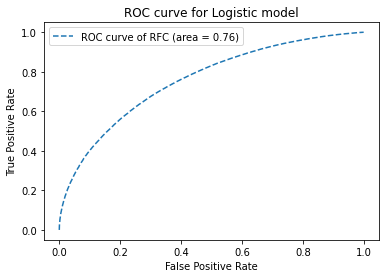


Classification Report

              precision    recall  f1-score   support

           0       0.64      0.43      0.52    106727
           1       0.74      0.87      0.80    198549

    accuracy                           0.72    305276
   macro avg       0.69      0.65      0.66    305276
weighted avg       0.71      0.72      0.70    305276


Confusion Matrix

[[ 46408  60319]
 [ 26192 172357]]


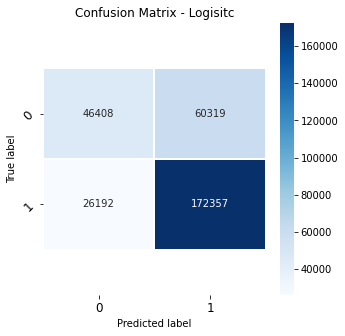

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.metrics import confusion_matrix

fpr, tpr, _ = roc_curve(Y_test, y_score[:, 1])

# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='--', label='ROC curve of RFC (area = {0:0.2f})'
             ''.format(roc))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.title('ROC curve for Logistic model')
plt.show()

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(Y_test, y_pred))

# build the confusion matrix
cnf_matrix = confusion_matrix(Y_test, y_pred)
print('\nConfusion Matrix\n')
print(cnf_matrix)

# plot resulting confusion matrix figure
fig, ax = plt.subplots(figsize=(5,5))
heatmap=sns.heatmap(cnf_matrix, linewidths=1,annot=True, fmt='',cmap='Blues')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45,  fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, fontsize=12)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix - Logisitc')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()